In [2]:
from src.utils import get_graph_data_from_topo
import src.constants as const
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

noise_config = {
    "missing_edges": 0.1,
    "wrong_edges": 0.1,
    "missing_nodes": 0.1,
    "rewired_edges": 0.1,
}

In [3]:
def remove_edges(G: nx.DiGraph, fraction: float) -> nx.DiGraph:
    """Remove a fraction of edges from the graph."""
    num_edges = G.number_of_edges()
    edges_to_remove = int(num_edges * fraction)
    edges = list(G.edges())
    G.remove_edges_from(edges[:edges_to_remove])
    #select largest weakly connected component in case of the graph being disconnected
    largest_wcc = max(nx.weakly_connected_components(G), key=len)
    G = G.subgraph(largest_wcc).copy()
    return G

def add_edges(G: nx.DiGraph, fraction: float) -> nx.DiGraph:
    """Add a fraction of edges to the graph, preferring sources with high out-degree and targets with high in-degree."""
    num_edges = G.number_of_edges()
    edges_to_add = int(num_edges * fraction)
    nodes = list(G.nodes())
    out_degrees = np.array([G.out_degree(n) for n in nodes], dtype=float)
    in_degrees = np.array([G.in_degree(n) for n in nodes], dtype=float)
    # Avoid division by zero
    if out_degrees.sum() == 0:
        out_probs = np.ones_like(out_degrees) / len(nodes)
    else:
        out_probs = out_degrees / out_degrees.sum()
    if in_degrees.sum() == 0:
        in_probs = np.ones_like(in_degrees) / len(nodes)
    else:
        in_probs = in_degrees / in_degrees.sum()
    for _ in range(edges_to_add):
        u = np.random.choice(nodes, p=out_probs)
        v = np.random.choice(nodes, p=in_probs)
        # Avoid self-loops and duplicate edges
        tries = 0
        while (u == v or G.has_edge(u, v)) and tries < 10:
            u = np.random.choice(nodes, p=out_probs)
            v = np.random.choice(nodes, p=in_probs)
            tries += 1
        if not G.has_edge(u, v):
            G.add_edge(u, v)
    return G

def remove_nodes(G: nx.DiGraph, fraction: float) -> nx.DiGraph:
    """Remove a fraction of nodes from the graph, preferring to remove low-degree nodes.
    When a node is removed, add transitive edges between its predecessors and successors.
    """
    num_nodes = G.number_of_nodes()
    nodes_to_remove = int(num_nodes * fraction)
    nodes = list(G.nodes())
    degrees = np.array([G.degree(n) for n in nodes], dtype=float)
    # Inverse degree: higher degree -> lower probability
    inv_degrees = 1 / (degrees + 1)  # add 1 to avoid division by zero
    probs = inv_degrees / inv_degrees.sum()
    nodes_selected = np.random.choice(nodes, size=nodes_to_remove, replace=False, p=probs)

    for node in nodes_selected:
        preds = list(G.predecessors(node))
        succs = list(G.successors(node))
        for u in preds:
            for v in succs:
                if not G.has_edge(u, v):
                    G.add_edge(u, v)
        G.remove_node(node)

    # select largest weakly connected component in case of the graph being disconnected
    assert G.number_of_nodes() > 0, "Graph is empty after node removal"
    largest_wcc = max(nx.weakly_connected_components(G), key=len)
    G = G.subgraph(largest_wcc).copy()

    return G

def rewire_edges(G: nx.DiGraph, fraction: float) -> nx.DiGraph:
    """Rewire a fraction of edges in the graph."""
    num_edges = G.number_of_edges()
    edges_to_rewire = int(num_edges * fraction)
    edges = list(G.edges())
    for _ in range(edges_to_rewire):
        u, v = edges[np.random.randint(len(edges))]
        new_u, new_v = np.random.choice(list(G.nodes()), 2, replace=False)
        G.remove_edge(u, v)
        G.add_edge(new_u, new_v)
    return G

In [4]:
def add_noise_to_graph(G: nx.DiGraph, noise_level: float = 0.1) -> nx.DiGraph:
    G_perturbed = remove_edges(G, noise_config["missing_edges"])
    G_perturbed = add_edges(G_perturbed, noise_config["wrong_edges"])
    G_perturbed = remove_nodes(G_perturbed, noise_config["missing_nodes"])
    G_perturbed = rewire_edges(G_perturbed, noise_config["rewired_edges"])
    return G_perturbed

In [5]:
def plot_graph(G):
    # plot the networkx graph
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G, seed=42)  # positions for all nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_edges(G, pos, width=2)
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    plt.title("Graph Visualization")
    plt.axis("off")
    plt.show()

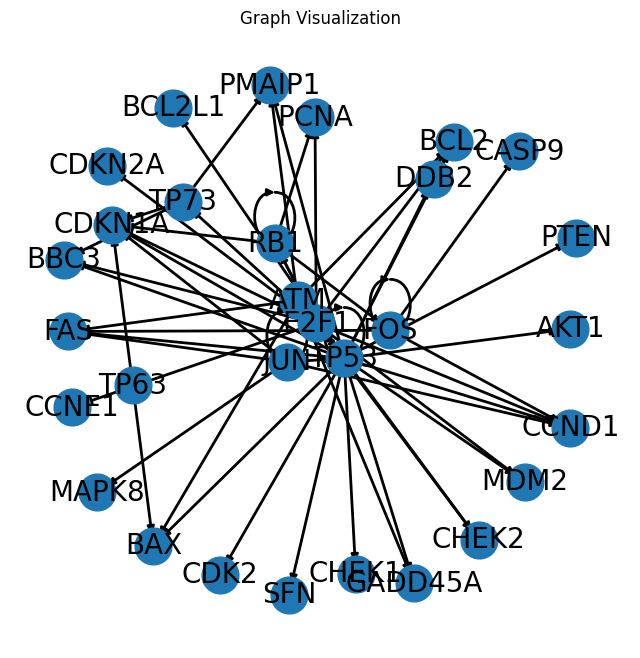

Number of nodes with outgoing edges: 9


In [ ]:
G,_ = get_graph_data_from_topo(f"{const.TOPO_PATH}/tp53.topo")
original_G = G.copy()
plot_graph(original_G)

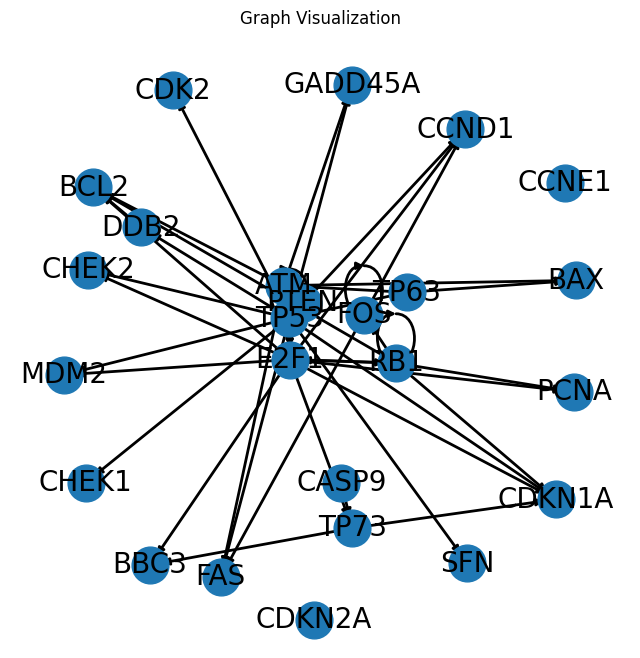

In [ ]:
G_perturbed = add_noise_to_graph(G, noise_level=0.1)
plot_graph(G_perturbed)

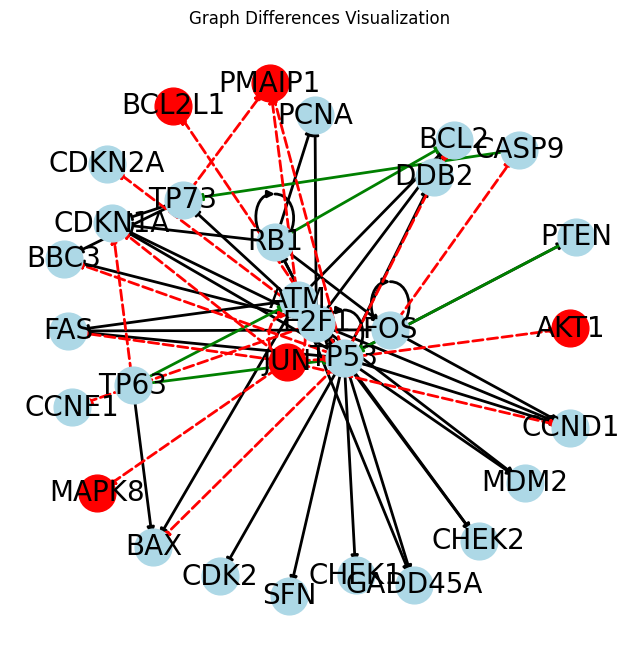

In [ ]:
def visualize_graph_differences(G_original: nx.DiGraph, G_perturbed: nx.DiGraph):
    # Find removed and added nodes
    original_nodes = set(G_original.nodes())
    perturbed_nodes = set(G_perturbed.nodes())
    removed_nodes = original_nodes - perturbed_nodes

    # Find removed and added edges
    original_edges = set(G_original.edges())
    perturbed_edges = set(G_perturbed.edges())
    removed_edges = original_edges - perturbed_edges
    added_edges = perturbed_edges - original_edges

    # For rewired edges, we consider edges that are both removed and added but between same nodes
    # For simplicity, highlight all removed and added edges as rewired if their nodes exist in both graphs
    rewired_edges = set()
    for e in removed_edges.copy():
        for a in added_edges.copy():
            if set(e) == set(a):
                rewired_edges.add(e)
                rewired_edges.add(a)
                removed_edges.discard(e)
                added_edges.discard(a)

    # Draw the perturbed graph as base
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G_original, seed=42)

    # Draw nodes
    nx.draw_networkx_nodes(G_perturbed, pos, node_color='lightblue', node_size=700)
    nx.draw_networkx_nodes(G_original, pos, nodelist=list(removed_nodes), node_color='red', node_size=700)

    # Draw edges
    nx.draw_networkx_edges(G_perturbed, pos, edgelist=list(perturbed_edges - added_edges - rewired_edges), width=2)
    nx.draw_networkx_edges(G_perturbed, pos, edgelist=list(added_edges), edge_color='green', width=2)
    nx.draw_networkx_edges(G_original, pos, edgelist=list(removed_edges), edge_color='red', width=2, style='dashed')
    nx.draw_networkx_edges(G_perturbed, pos, edgelist=list(rewired_edges), edge_color='yellow', width=2, style='dotted')

    # Draw labels
    nx.draw_networkx_labels(G_original, pos, font_size=20, font_family="sans-serif")

    plt.title("Graph Differences Visualization")
    plt.axis("off")
    plt.show()

visualize_graph_differences(original_G, G_perturbed)
